In this tutorial we will see the explore the basic feature of **Elegy**. If you are a Keras user you should feel at home, are currently using Jax or Haiku things will appear much simpler. To get started you will first need to install the following dependencies:

In [ ]:
! pip install elegy dataget matplotlibpip install elegy dataget matplotlib

## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need download and load the data into memory. Here we will use `dataget` for simplicity but you can probably use you favorite datasets library.

In [1]:
import dataget

X_train, y_train, X_test, y_test = dataget.image.mnist(global_cache=True).get()

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

X_train: (60000, 28, 28) uint8
y_train: (60000,) uint8
X_test: (10000, 28, 28) uint8
y_test: (10000,) uint8


In this case `dataget` loads is the _official_ from Yann LeCun's website.

## Creating the Model
Now that we have the data we can define function for our model. This function should take in some inputs, perform a series of transformation using Jax and Haiku expressions, and returns some outputs, easy right?. In this example we will create a simple 2 layer MLP using Haiku modules: 

In [40]:
import jax.numpy as jnp
import jax
import haiku as hk

def model_fn(image) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    image = image.astype(jnp.float32) / 255.0

    mlp = hk.Sequential(
        [
            hk.Flatten(),
            hk.Linear(300),
            jax.nn.relu,
            hk.Linear(100),
            jax.nn.relu,
            hk.Linear(10),
        ]
    )
    return mlp(image)

Here we are using `Sequential` to stack two layers with `relu` activations and a final `Linear` layer with `10` units that represents the logits of the network. This code should feel familiar to most Keras / PyTorch users, the main difference here is that instead of assigning Modules / Layers as fields in a class we just create modules and use them inplace since Haiku tracks the state for us "behind the scenes". Because of this, writing often feels a bit magical and makes writing code easier. For a premier on Haiku please refer to this [Quick Start](https://github.com/deepmind/dm-haiku#quickstart).

**Note:** This style is very similar to Keras functional API instead that this time you actually have a function.

Now that we have this function we can create an Elegy `Model`

In [44]:
import elegy
from jax.experimental import optix

model = elegy.Model(
    model_fn=model_fn,
    loss=lambda: elegy.losses.SparseCategoricalCrossentropy(from_logits=True),
    aux_losses=lambda: elegy.regularizers.GlobalL2(l=1e-5),
    metrics=lambda: elegy.metrics.SparseCategoricalAccuracy(),
    optimizer=optix.rmsprop(0.001),
)

In [45]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
)

Epoch 1/100
200/200 [==============================] - 2s 11ms/step - l2_regularization_loss: 0.0041 - loss: 0.3141 - sparse_categorical_accuracy: 0.8516 - sparse_categorical_crossentropy_loss: 0.3100 - size: 64.0000 - val_l2_regularization_loss: 0.0041 - val_loss: 0.1448 - val_sparse_categorical_accuracy: 0.9036 - val_sparse_categorical_crossentropy_loss: 0.1406 - val_size: 64.0000
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0046 - loss: 0.2372 - sparse_categorical_accuracy: 0.9264 - sparse_categorical_crossentropy_loss: 0.2326 - size: 64.0000 - val_l2_regularization_loss: 0.0046 - val_loss: 0.0365 - val_sparse_categorical_accuracy: 0.9443 - val_sparse_categorical_crossentropy_loss: 0.0318 - val_size: 64.0000
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0050 - loss: 0.3850 - sparse_categorical_accuracy: 0.9466 - sparse_categorical_crossentropy_loss: 0.3799 - size: 64.0000 - val_l2_regu

200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0083 - loss: 0.0103 - sparse_categorical_accuracy: 0.9875 - sparse_categorical_crossentropy_loss: 0.0020 - size: 64.0000 - val_l2_regularization_loss: 0.0083 - val_loss: 0.0083 - val_sparse_categorical_accuracy: 0.9814 - val_sparse_categorical_crossentropy_loss: 1.8223e-05 - val_size: 64.0000
Epoch 23/100
200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0084 - loss: 0.0117 - sparse_categorical_accuracy: 0.9859 - sparse_categorical_crossentropy_loss: 0.0033 - size: 64.0000 - val_l2_regularization_loss: 0.0084 - val_loss: 0.0086 - val_sparse_categorical_accuracy: 0.9797 - val_sparse_categorical_crossentropy_loss: 1.8989e-04 - val_size: 64.0000
Epoch 24/100
200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0085 - loss: 0.0789 - sparse_categorical_accuracy: 0.9892 - sparse_categorical_crossentropy_loss: 0.0704 - size: 64.0000 - val_l2_regular

200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0096 - loss: 0.0176 - sparse_categorical_accuracy: 0.9944 - sparse_categorical_crossentropy_loss: 0.0080 - size: 64.0000 - val_l2_regularization_loss: 0.0096 - val_loss: 0.0096 - val_sparse_categorical_accuracy: 0.9808 - val_sparse_categorical_crossentropy_loss: 9.2387e-07 - val_size: 64.0000
Epoch 44/100
200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0096 - loss: 0.0114 - sparse_categorical_accuracy: 0.9946 - sparse_categorical_crossentropy_loss: 0.0018 - size: 64.0000 - val_l2_regularization_loss: 0.0096 - val_loss: 0.0096 - val_sparse_categorical_accuracy: 0.9803 - val_sparse_categorical_crossentropy_loss: 7.5546e-06 - val_size: 64.0000
Epoch 45/100
200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0096 - loss: 0.0146 - sparse_categorical_accuracy: 0.9944 - sparse_categorical_crossentropy_loss: 0.0050 - size: 64.0000 - val_l2_regular

200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0098 - loss: 0.0147 - sparse_categorical_accuracy: 0.9951 - sparse_categorical_crossentropy_loss: 0.0049 - size: 64.0000 - val_l2_regularization_loss: 0.0098 - val_loss: 0.0098 - val_sparse_categorical_accuracy: 0.9806 - val_sparse_categorical_crossentropy_loss: 1.4901e-07 - val_size: 64.0000
Epoch 65/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0098 - loss: 0.0453 - sparse_categorical_accuracy: 0.9950 - sparse_categorical_crossentropy_loss: 0.0355 - size: 64.0000 - val_l2_regularization_loss: 0.0098 - val_loss: 0.0098 - val_sparse_categorical_accuracy: 0.9759 - val_sparse_categorical_crossentropy_loss: 3.3602e-06 - val_size: 64.0000
Epoch 66/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0098 - loss: 0.0113 - sparse_categorical_accuracy: 0.9962 - sparse_categorical_crossentropy_loss: 0.0015 - size: 64.0000 - val_l2_regular

Epoch 85/100
200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0096 - loss: 0.0267 - sparse_categorical_accuracy: 0.9973 - sparse_categorical_crossentropy_loss: 0.0170 - size: 64.0000 - val_l2_regularization_loss: 0.0096 - val_loss: 0.0096 - val_sparse_categorical_accuracy: 0.9799 - val_sparse_categorical_crossentropy_loss: 2.2352e-08 - val_size: 64.0000
Epoch 86/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0096 - loss: 0.0318 - sparse_categorical_accuracy: 0.9968 - sparse_categorical_crossentropy_loss: 0.0222 - size: 64.0000 - val_l2_regularization_loss: 0.0096 - val_loss: 0.0096 - val_sparse_categorical_accuracy: 0.9792 - val_sparse_categorical_crossentropy_loss: 2.9802e-07 - val_size: 64.0000
Epoch 87/100
200/200 [==============================] - 1s 4ms/step - l2_regularization_loss: 0.0096 - loss: 0.0228 - sparse_categorical_accuracy: 0.9959 - sparse_categorical_crossentropy_loss: 0.0132 - size: 64.0000 - v

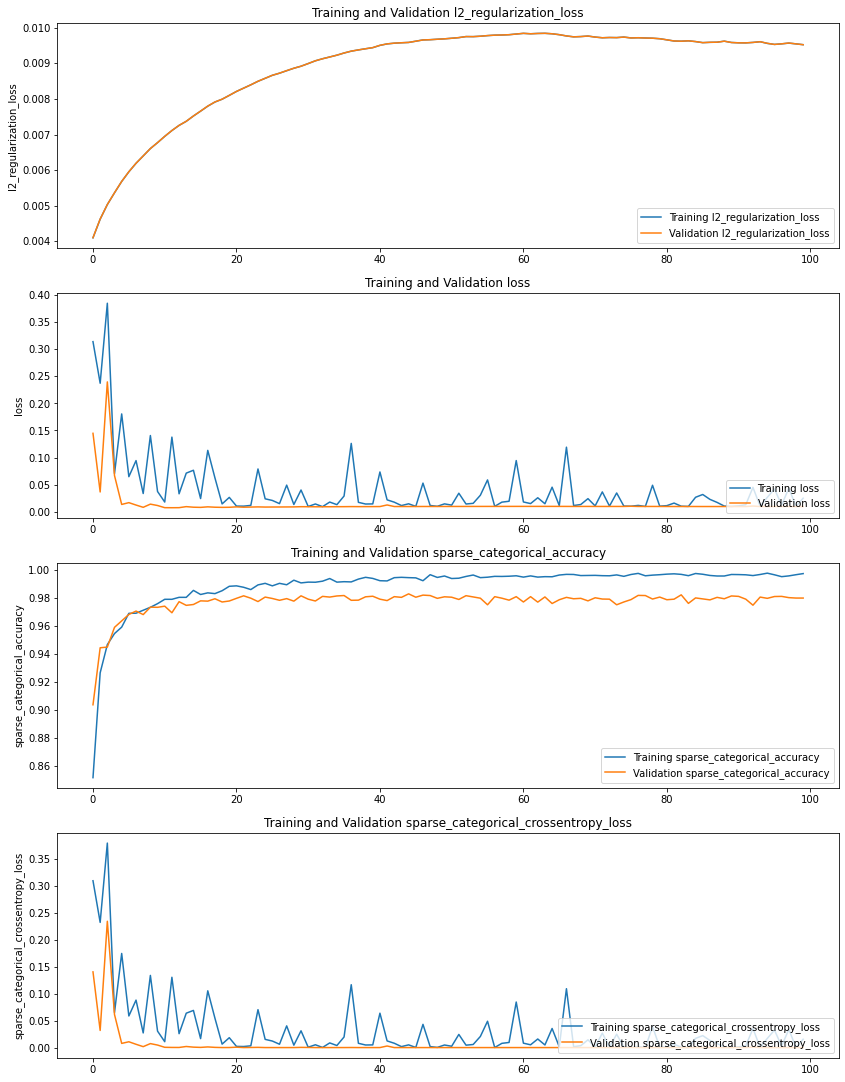

In [46]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        if key == "size":
            continue
        
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
#         plt.ylim([min(plt.ylim()), 1])
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

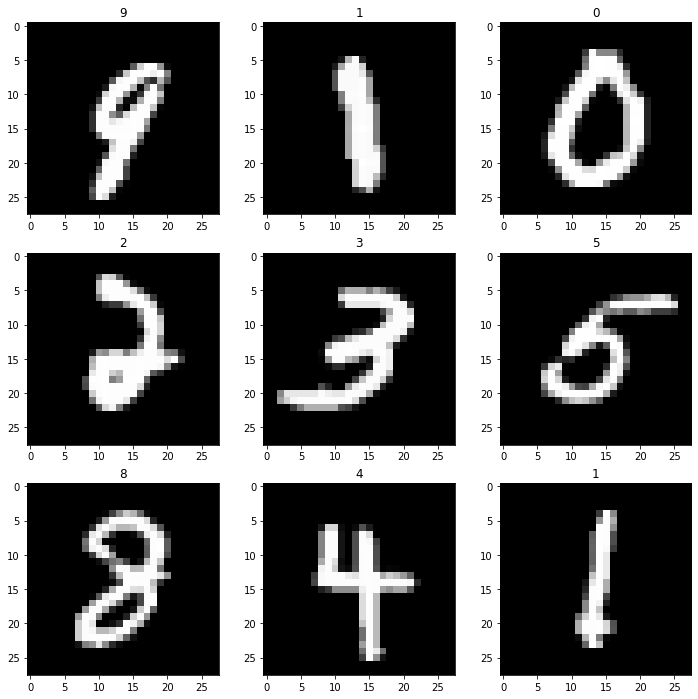

In [47]:
import numpy as np

# get random samples
idxs = np.random.randint(0, 10000, size=(9,))
x_sample = X_test[idxs]

# get predictions
y_pred = model.predict(x=x_sample)

# plot results
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")